# Discriminative text model

We make text a parent of the nodes pneu, inf, dysp, cough and nasal. This means each of their conditional probability distributions is modeled as the output of a text classifier, one for each non-text parent configuration. For example, P(dysp|pneu,text) is parameterized by two classifiers that take text embeddings as an input, one for P(dysp|pneu=yes,text) and one for P(dysp|pneu=no,text). 

![title](figures\models_discr.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
with open("data/train_4000_final.p", "rb") as file: 
    train_df = pickle.load(file)

In [3]:
import pickle
with open("data/test_1000_final.p", "rb") as file: 
    test_df = pickle.load(file)

In [4]:
class_map = {"season": {"warm": 0, "cold": 1}, 
            "pneu": {"no": 0, "yes": 1}, "inf": {"no": 0, "yes": 1}, 
            "dysp": {"no": 0, "yes": 1}, "cough": {"no": 0, "yes": 1}, "nasal": {"no": 0, "yes": 1}}

In [5]:
from utils.data import TabDataset
import torch

emb_type = "BioLORD emb"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # put train and test data on the device
print(device)
train_set = TabDataset(train_df, class_map, emb_type, device)
test_set = TabDataset(test_df, class_map, emb_type, device)

c:\Users\Paloma\anaconda3\envs\bn-text\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


c:\Users\Paloma\Work\bn-text\utils\data.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  preprocessed_data["text"] = torch.tensor(self.dataframe[self.emb_type].tolist(), dtype=torch.float, device=self.device)


In utils.models, you can find the class DiscriminativeModel. This implements the Bayesian network with text classifiers as shown in the figure, using the class TextEmbClassifier to model the text classifiers. 

In [6]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
from utils.models import DiscriminativeModel, DiscriminativeModelAbl

def train_model_discriminative(train, test, n_emb, hidden_dim, dropout, node_names, cpt_names, device, model_type="discr", bs_train=100, epochs=100, seed=2023, lr_cpt=0.05, lr_nn=0.001, weight_decay=1e-5):
    """
    training loop for learning all parameters of BN with text discriminator
    
    train: set of training samples
    test: set of test samples
    n_emb: text embedding dimension
    hidden_dim: dict {var_name: [...]} containing list of hidden dimensions to use in text classifiers
    dropout: dict {var_name: ...} containing dropout probability to use in text classifiers
    node_names: list of names of all nodes in the BN (except text)
    cpt_names: list of names of all nodes in the BN for which a regular conditional probability table is learned (no text classifier)
    device: device to load the model to (GPU/CPU)
    model_type: type of model ("discr" or "discr_abl")
    
    bs_train: batch size to use for training
    epochs: number of epochs to train for
    seed: seed to use for initialization
    lr_cpt: learning rate to use for learning conditional probability table parameters
    lr_nn: learning rate to use for learning text classifier weights
    weight_decay: weight decay to use in Adam optimizer for learning text classifier weights

    returns
        train_loss: dict of individual train losses across epochs (i.e. logP for each separate conditional distribution)
        test_loss: dict of individual test losses across epochs (i.e. logP for each separate conditional distribution)
        model: trained BN with text discriminators
    """
    
    torch.manual_seed(seed)
    
    train_loader = DataLoader(train, batch_size=bs_train, shuffle=True)
    test_loader = DataLoader(test, batch_size=len(test), shuffle=False)

    # put model on the device
    if model_type == "discr": 
        model = DiscriminativeModel(n_emb, hidden_dim, dropout, seed, device)
        model.to(device)
    elif model_type == "discr_abl":
        model = DiscriminativeModelAbl(n_emb, hidden_dim, dropout, seed, device)
        model.to(device)

    # use different learning rate for the CPT parameters vs. the NN parameters
    params_cpt = []
    params_nn = []
    for name, param in model.named_parameters():
        if "lin" in name: 
            params_nn.append(param) ## NN params
        elif name.split(".")[1] in cpt_names:
            params_cpt.append(param) ## CPT params
        else: 
            print("unknown parameter")
    param_groups = [{"params": params_cpt, "lr": lr_cpt}, {"params": params_nn, "lr": lr_nn, "weight_decay": weight_decay}]
    adam = Adam(param_groups)

    train_loss = {key:[] for key in node_names}
    test_loss = {key:[] for key in node_names}

    for epoch in range(epochs):

        model.train() # put model in train mode
        epoch_loss = {key:0 for key in node_names}

        for i, x in enumerate(train_loader): 

            adam.zero_grad()

            losses = model(x) # log likelihood of batch under current parametrization of the model
            LL = {key: loss.sum() for key, loss in losses.items()}
            batch_loss = -sum(LL.values()) # batch loss is sum of all individual losses 
            batch_loss.backward()

            epoch_loss = {key: loss + -LL[key].item() for key, loss in epoch_loss.items()} # store total losses for individual variables per epoch
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            adam.step()
        
        train_loss = {key: loss_list + [epoch_loss[key]] for key, loss_list in train_loss.items()}

        model.eval() # put model in evaluation mode
        with torch.no_grad():
            for x_test in test_loader: 
                losses = model(x_test)
                LL = {key: loss.sum() for key, loss in losses.items()}
                test_loss = {key: loss_list + [-LL[key].item()] for key, loss_list in test_loss.items()}

    for key in train_loss: 
        if key in ["dysp", "nasal", "cough"]:
            train_loss[key] = [e/train.len_sympt_obs() for e in train_loss[key]] # only count the times when this loss was counted = number of records where symptoms are observed
            test_loss[key] = [e/test.len_sympt_obs() for e in test_loss[key]]
        else: 
            train_loss[key] = [e/len(train) for e in train_loss[key]]  # loss was counted for every train record because always observed
            test_loss[key] = [e/len(test) for e in test_loss[key]]

    return train_loss, test_loss, model

The hyperparameters bs_train, epochs and lr were optimized using a separate train/val split. 

In [ ]:
from sklearn.model_selection import train_test_split
seed = 2024
subtrain_df, val_df = train_test_split(train_df, train_size=0.8, random_state=seed) # use val_df in code below to optimize hyperparameters

Using this train/val split, we landed on the configuration below. 

In [10]:
n_emb = 768
hidden_dim = {"pneu": [256, 1], "inf": [1], "dysp": [1], "cough": [1], "nasal": [1]}
dropout = {"pneu": 0.7, "inf": 0.7, "dysp": 0, "cough": 0, "nasal": 0}
bs_train = 256
epochs = 200
lr_cpt = 0.05
lr_nn = 0.001
weight_decay = 1e-3
node_names = ["season", "pneu", "inf", "dysp", "cough", "nasal"]
cpt_names = ["season"]
seed = 2024

train_loss_individual, test_loss_individual, model = train_model_discriminative(train_set, test_set, n_emb, hidden_dim, dropout, node_names, cpt_names, device, bs_train=bs_train, epochs=epochs, seed=seed, lr_cpt=lr_cpt, lr_nn=lr_nn, weight_decay=weight_decay)

The plot below shows that all invidiual CPT losses have converged. 

In [11]:
import numpy as np
# calculate total loss from individual train and test loss
total_train = np.zeros(len(train_loss_individual["pneu"]))
for key, val in train_loss_individual.items():
    total_train += val
total_test = np.zeros(len(test_loss_individual["pneu"]))
for key, val in test_loss_individual.items():
    total_test += val

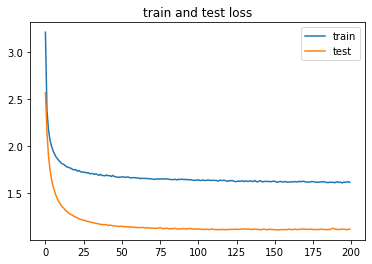

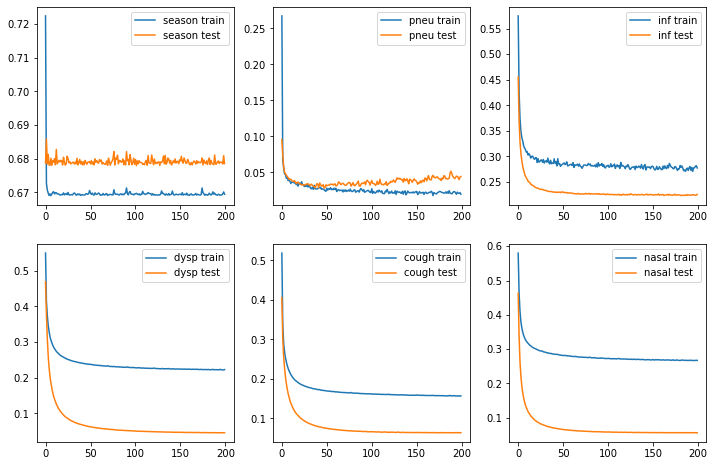

In [12]:
from utils.evaluation import plot_loss
plot_loss(train_loss_individual, test_loss_individual, epochs, total_train, total_test)

Finally, we can use the fitted model to predict the following probabilities: 
- P(Diag=yes|background,symptoms,text)
- P(Diag=yes|background,symptoms) 
- P(Diag=yes|background,text)

We use an exact Bayesian inference procedure for this, which is implemented in infer_query and used by the predict_diagnoses function (see utils.evaluation). 

We also calculate the KL divergence between the learned CPTs and the ground-truth CPTs. 

The code below fits the discriminative model for 5 seeds and calculates these outcomes for every seed. 

In [7]:
from utils.evaluation import CPD_params, predict_diagnoses, performance_metrics

class_map = {"season": {"warm": 0, "cold": 1}, 
            "pneu": {"no": 0, "yes": 1}, "inf": {"no": 0, "yes": 1}, 
            "dysp": {"no": 0, "yes": 1}, "cough": {"no": 0, "yes": 1}, "nasal": {"no": 0, "yes": 1}}
    
n_emb = 768
hidden_dim = {"pneu": [256, 1], "inf": [1], "dysp": [1], "cough": [1], "nasal": [1]}
dropout = {"pneu": 0.7, "inf": 0.7, "dysp": 0, "cough": 0, "nasal": 0}
bs_train = 256
epochs = 200
lr_cpt = 0.05
lr_nn = 0.001
weight_decay = 1e-3
node_names = ["season", "pneu", "inf", "dysp", "cough", "nasal"]
cpt_names = ["season"]

emb_type = "BioLORD emb"
empty_text_emb = torch.tensor(train_df[train_df["text"] == ""].iloc[0][emb_type]) # empty text embedding for evaluation purposes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seeds = [422, 957, 267, 956, 781]

results = {}

for seed in seeds:

    results[seed] = {}

    ## TRAINING ##
    
    _, _, model = train_model_discriminative(train_set, test_set, n_emb, hidden_dim, dropout, node_names, cpt_names, device, bs_train=bs_train, epochs=epochs, seed=seed, lr_cpt=lr_cpt, lr_nn=lr_nn, weight_decay=weight_decay)

    ## EVALUATION ##

    # KL divergence
    _, _, KL = CPD_params(model, "discr", empty_text_emb=empty_text_emb)
    results[seed][f"KL"] = KL

    # P(pneu=yes|background,symptoms,text)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="discr", empty_text_emb=empty_text_emb)
    _, ap = performance_metrics(pred_df, "pneu", model_type="discr", plot=False) 
    results[seed][f"P(pneu|season,symptoms,text) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="discr", plot=False) 
    results[seed][f"P(inf|season,symptoms,text) test PR"] = ap

    # P(pneu=yes|background,symptoms)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="discr", excl_text=True, empty_text_emb=empty_text_emb)
    _, ap = performance_metrics(pred_df, "pneu", model_type="discr", plot=False) 
    results[seed][f"P(pneu|season,symptoms) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="discr", plot=False) 
    results[seed][f"P(inf|season,symptoms) test PR"] = ap

    # P(pneu=yes|background,text)
    pred_df = predict_diagnoses(model, test_set, 100, model_type="discr", excl_sympt=True, empty_text_emb=empty_text_emb)
    _, ap = performance_metrics(pred_df, "pneu", model_type="discr", plot=False) 
    results[seed][f"P(pneu|season,text) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="discr", plot=False) 
    results[seed][f"P(inf|season,text) test PR"] = ap

cpu


In [8]:
results

{422: {'KL': 0.008928098188671928,
  'P(pneu|season,symptoms,text) test PR': 0.7670523259808975,
  'P(inf|season,symptoms,text) test PR': 0.9016219600703267,
  'P(pneu|season,symptoms) test PR': 0.10638791883735683,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.6997384386978757,
  'P(inf|season,text) test PR': 0.8735221266440443},
 957: {'KL': 0.011345678846366497,
  'P(pneu|season,symptoms,text) test PR': 0.782641857969185,
  'P(inf|season,symptoms,text) test PR': 0.9016735137311078,
  'P(pneu|season,symptoms) test PR': 0.10869365312826833,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.7261935209284252,
  'P(inf|season,text) test PR': 0.8739028444487781},
 267: {'KL': 0.008352948108465793,
  'P(pneu|season,symptoms,text) test PR': 0.7426923354791822,
  'P(inf|season,symptoms,text) test PR': 0.9027957283998973,
  'P(pneu|season,symptoms) test PR': 0.10879815002279707,
  'P(inf|season,symptoms) tes

## Ablation of discriminative text model

We remove the arrow from text -> pneu and from text -> inf. Now, the nodes pneu and inf can be modeled using regular conditional probability tables, instead of as text classifiers. The nodes dysp, cough and nasal are still modeled as text classifiers. 

Again, we run over 5 initialization seeds. 

In [9]:
from utils.evaluation import CPD_params, predict_diagnoses, performance_metrics

class_map = {"season": {"warm": 0, "cold": 1}, 
            "pneu": {"no": 0, "yes": 1}, "inf": {"no": 0, "yes": 1}, 
            "dysp": {"no": 0, "yes": 1}, "cough": {"no": 0, "yes": 1}, "nasal": {"no": 0, "yes": 1}}
    
n_emb = 768
hidden_dim = {"dysp": [1], "cough": [1], "nasal": [1]}
dropout = {"dysp": 0, "cough": 0, "nasal": 0}
bs_train = 256
epochs = 200
lr_cpt = 0.05
lr_nn = 0.001
weight_decay = 1e-3
node_names = ["season", "pneu", "inf", "dysp", "cough", "nasal"]
cpt_names = ["season", "pneu", "inf"]

emb_type = "BioLORD emb"
empty_text_emb = torch.tensor(train_df[train_df["text"] == ""].iloc[0][emb_type]) # empty text embedding for evaluation purposes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seeds = [422, 957, 267, 956, 781]

results = {}

for seed in seeds:

    results[seed] = {}

    ## TRAINING ##
    
    _, _, model = train_model_discriminative(train_set, test_set, n_emb, hidden_dim, dropout, node_names, cpt_names, device, model_type="discr_abl", bs_train=bs_train, epochs=epochs, seed=seed, lr_cpt=lr_cpt, lr_nn=lr_nn, weight_decay=weight_decay)

    ## EVALUATION ##

    # KL divergence
    _, _, KL = CPD_params(model, "discr_abl", empty_text_emb=empty_text_emb)
    results[seed][f"KL"] = KL

    # P(pneu=yes|background,symptoms,text)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="discr_abl", empty_text_emb=empty_text_emb)
    _, ap = performance_metrics(pred_df, "pneu", model_type="discr_abl", plot=False) 
    results[seed][f"P(pneu|season,symptoms,text) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="discr_abl", plot=False) 
    results[seed][f"P(inf|season,symptoms,text) test PR"] = ap

    # P(pneu=yes|background,symptoms)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="discr_abl", excl_text=True, empty_text_emb=empty_text_emb)
    _, ap = performance_metrics(pred_df, "pneu", model_type="discr_abl", plot=False) 
    results[seed][f"P(pneu|season,symptoms) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="discr_abl", plot=False) 
    results[seed][f"P(inf|season,symptoms) test PR"] = ap

    # P(pneu=yes|background,text)
    pred_df = predict_diagnoses(model, test_set, 100, model_type="discr_abl", excl_sympt=True, empty_text_emb=empty_text_emb)
    _, ap = performance_metrics(pred_df, "pneu", model_type="discr_abl", plot=False) 
    results[seed][f"P(pneu|season,text) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="discr_abl", plot=False) 
    results[seed][f"P(inf|season,text) test PR"] = ap

cpu


In [10]:
results

{422: {'KL': 0.005247393034132819,
  'P(pneu|season,symptoms,text) test PR': 0.10300327786307287,
  'P(inf|season,symptoms,text) test PR': 0.8061383026722112,
  'P(pneu|season,symptoms) test PR': 0.10672846933492644,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.03022864060878589,
  'P(inf|season,text) test PR': 0.4441163639127461},
 957: {'KL': 0.004837046875179437,
  'P(pneu|season,symptoms,text) test PR': 0.10226481933047933,
  'P(inf|season,symptoms,text) test PR': 0.8071503518907083,
  'P(pneu|season,symptoms) test PR': 0.08975213910558417,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.03022864060878589,
  'P(inf|season,text) test PR': 0.4441163639127461},
 267: {'KL': 0.007807039304489337,
  'P(pneu|season,symptoms,text) test PR': 0.10118044235502023,
  'P(inf|season,symptoms,text) test PR': 0.8068064523442345,
  'P(pneu|season,symptoms) test PR': 0.10869365312826833,
  'P(inf|season,symptom